This notebook is for testing concepts I learnt from Andrew Ng's famous Machine Learning course. I will be building a classification model using NN with regularization. As for the data, I will be using the Titanic Dataset that I have previously worked with.

In [171]:
import pandas as pd
import re
import numpy as np
from scipy.special import expit
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import seaborn as sns

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
train_copy = train

## Data Exploration

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
pd.crosstab(train.Embarked,train.Survived)

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


In [7]:
train['Name'] = train['Name'].apply(lambda x : (re.search(' ([a-zA-Z]+)\.', x)).group(1))
test['Name'] = test['Name'].apply(lambda x : (re.search(' ([a-zA-Z]+)\.', x)).group(1))

In [8]:
train['Name'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [9]:
title = {'Capt':       'Officer',
          'Col':        'Officer',
          'Major':      'Officer',
          'Jonkheer':   'Royalty',
          'Don':        'Royalty',
          'Sir' :       'Royalty',
          'Dr':         'Officer',
          'Rev':        'Officer',
          'Countess':   'Royalty',
          'Dona':       'Royalty',
          'Mme':        'Mrs',
          'Mlle':       'Miss',
          'Ms':         'Mrs',
          'Mr' :        'Mr',
          'Mrs' :       'Mrs',
          'Miss' :      'Miss',
          'Master' :    'Master',
          'Lady' :      'Royalty'
    } 

In [10]:
for x,y in title.items():
    train.loc[train['Name'] == x,'Name'] = y
    test.loc[test['Name'] == x,'Name'] = y

In [11]:
train.Name.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [14]:
train.loc[train.Cabin.isnull(),'Cabin'] = 'U'
test.loc[test.Cabin.isnull(),'Cabin'] = 'U'

In [15]:
train.Cabin.unique()

array(['U', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Since there are a lot of unique values, we can group them up to form fewer classes

In [16]:
train['cabin_new'] = train['Cabin'].apply(lambda x: (re.search('([a-zA-Z])', x)).group(1))
test['cabin_new'] = test['Cabin'].apply(lambda x: (re.search('([a-zA-Z])', x)).group(1))

In [17]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_new
0,1,0,3,Mr,male,22.0,1,0,A/5 21171,7.2500,U,S,U
1,2,1,1,Mrs,female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,Miss,female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,U
3,4,1,1,Mrs,female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,Mr,male,35.0,0,0,373450,8.0500,U,S,U


In [18]:
train.Ticket.unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [19]:
train.Ticket.apply(lambda x : (re.search('[(a-zA-Z)*]',x)))

0      <re.Match object; span=(0, 1), match='A'>
1      <re.Match object; span=(0, 1), match='P'>
2      <re.Match object; span=(0, 1), match='S'>
3                                           None
4                                           None
                         ...                    
886                                         None
887                                         None
888    <re.Match object; span=(0, 1), match='W'>
889                                         None
890                                         None
Name: Ticket, Length: 891, dtype: object

In [20]:
def reduce(x):
    s = x.split()
    l = len(s)
    if l == 3:
        return s[0]+s[1]
    elif l == 2:
        return s[0]
    else:
        return 'None'
def extract(x):
    return " ".join(re.split("[^a-zA-Z]*", x)).replace(" ","")

In [21]:
train['Ticket'] = train['Ticket'].apply(reduce)
train['Ticket'] = train['Ticket'].apply(extract)
test['Ticket'] = test['Ticket'].apply(reduce)
test['Ticket'] = test['Ticket'].apply(extract)

In [22]:
train.Ticket.unique()

array(['A', 'PC', 'STONO', 'None', 'PP', 'CA', 'SCParis', 'SCA', 'SP',
       'SOC', 'WC', 'SOTONOQ', 'WEP', 'C', 'SCPARIS', 'SOP', 'Fa', 'FCC',
       'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH', 'AS', 'SCAHBasle', 'SOPP',
       'FC', 'SOTONO', 'CASOTON'], dtype=object)

In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_new
0,1,0,3,Mr,male,22.0,1,0,A,7.2500,U,S,U
1,2,1,1,Mrs,female,38.0,1,0,PC,71.2833,C85,C,C
2,3,1,3,Miss,female,26.0,0,0,STONO,7.9250,U,S,U
3,4,1,1,Mrs,female,35.0,1,0,None,53.1000,C123,S,C
4,5,0,3,Mr,male,35.0,0,0,None,8.0500,U,S,U


In [24]:
def family(x):
    if x == 0:
        return 'alone'
    elif x >=1 and x<3:
        return 'some'
    elif x >=3 and x<5:
        return 'medium'
    else:
        return 'alot'

In [25]:
train['family'] = train['SibSp']+train['Parch']
test['family'] = test['SibSp']+test['Parch']
train['family'] = train.family.apply(family)
test['family'] = test.family.apply(family)

In [26]:
train.family.value_counts()

alone     537
some      263
alot       47
medium     44
Name: family, dtype: int64

In [27]:
pd.crosstab(train.family,train.Survived)

Survived,0,1
family,,
alone,374,163
alot,40,7
medium,20,24
some,115,148


Most people who were alone did not survive. Same with people who were with a lot of family members.

In [28]:
train.isnull().mean()*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin           0.000000
Embarked        0.224467
cabin_new       0.000000
family          0.000000
dtype: float64

In [29]:
train['Age'] = train.groupby(['Sex','Pclass','Name'])['Age'].apply(lambda x : x.fillna(x.median()))
test['Age'] = test.groupby(['Sex','Pclass','Name'])['Age'].apply(lambda x : x.fillna(x.median()))

In [30]:
test.loc[test.Fare.isna(),'Fare'] = test.Fare.median()

In [31]:
train.isnull().mean()*100

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.000000
Embarked       0.224467
cabin_new      0.000000
family         0.000000
dtype: float64

In [32]:
countlist = train.groupby('Embarked').count()['PassengerId']
train.Embarked.fillna(countlist.idxmax(),inplace = True)

In [33]:
pd.crosstab(train.Embarked,train.Survived)

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,219


In [34]:
train.isnull().mean()*100

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
cabin_new      0.0
family         0.0
dtype: float64

Getting rid of PassengerId, Cabin and storing Survived in y.

In [35]:
passngr = test.PassengerId
y = train['Survived']
for i in ['PassengerId','Cabin','SibSp','Parch']:
    train.drop([i],axis = 1,inplace = True)
    test.drop([i],axis = 1,inplace = True)
X = train.drop(['Survived'],axis = 1)

In [36]:
X.head()

,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,cabin_new,family
0,3,Mr,male,22.0,A,7.2500,S,U,some
1,1,Mrs,female,38.0,PC,71.2833,C,C,some
2,3,Miss,female,26.0,STONO,7.9250,S,U,alone
3,1,Mrs,female,35.0,None,53.1000,S,C,some
4,3,Mr,male,35.0,None,8.0500,S,U,alone


In [37]:
col = ['Pclass','Name','Sex','Ticket','Embarked','cabin_new','family']
for c in col:
    temp = pd.get_dummies(X[c],drop_first = False)
    temp = temp.add_prefix('{}_'.format(c))
    X.drop(c, axis=1, inplace=True)
    X = X.join(temp)
for c in col:
    temp = pd.get_dummies(test[c],drop_first = False)
    temp = temp.add_prefix('{}_'.format(c))
    test.drop(c, axis=1, inplace=True)
    test = test.join(temp)
X.head()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_Officer,...,cabin_new_D,cabin_new_E,cabin_new_F,cabin_new_G,cabin_new_T,cabin_new_U,family_alone,family_alot,family_medium,family_some
0,22.0,7.2500,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
1,38.0,71.2833,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,26.0,7.9250,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,35.0,53.1000,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0


In [38]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
X_new = X.copy(deep = True)
test_new = test.copy(deep = True)
norm_train = mm.fit_transform(X_new[['Age','Fare']])
norm_test = mm.transform(test_new[['Age','Fare']])
X_new[['Age','Fare']] = norm_train
test_new[['Age','Fare']] = norm_test

In [39]:
X_new.describe()

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_Officer,...,cabin_new_D,cabin_new_E,cabin_new_F,cabin_new_G,cabin_new_T,cabin_new_U,family_alone,family_alot,family_medium,family_some
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.360873,0.062858,0.242424,0.206510,0.551066,0.044893,0.206510,0.580247,0.142536,0.020202,...,0.037037,0.035915,0.014590,0.004489,0.001122,0.771044,0.602694,0.052750,0.049383,0.295174
std,0.169580,0.096995,0.428790,0.405028,0.497665,0.207186,0.405028,0.493796,0.349796,0.140770,...,0.188959,0.186182,0.119973,0.066890,0.033501,0.420397,0.489615,0.223659,0.216787,0.456377
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258608,0.015440,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.321438,0.028213,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.456522,0.060508,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:
X_new.insert(0, 'bias', 1)
test_new.insert(0, 'bias', 1)
X_new.head()

,bias,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Name_Master,Name_Miss,Name_Mr,Name_Mrs,...,cabin_new_D,cabin_new_E,cabin_new_F,cabin_new_G,cabin_new_T,cabin_new_U,family_alone,family_alot,family_medium,family_some
0,1,0.271174,0.014151,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,1,0.472229,0.139136,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0.321438,0.015469,0,0,1,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
3,1,0.434531,0.103644,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,1,0.434531,0.015713,0,0,1,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0


Building the Neural Network

In [41]:
hidden_layer_size = 30
alpha = 1
weights = np.random.random(size = hidden_layer_size*X_new.shape[1]+(hidden_layer_size+1)*1) - 0.5

In [42]:
def forwardprop(X, theta1, theta2):
    z2 = X*theta1.T
    #sigmoid function
    a2 = np.insert(expit(z2),0,1,axis = 1)
    a3 = expit(a2*theta2.T)
    return z2, a2, a3

expit function: The expit function, also known as the logistic sigmoid function, is defined as expit(x) = 1/(1+exp(-x)). It is the inverse of the logit function.

In [85]:
def backprop(X, y, theta1, theta2, z2, a2, a3):
    D1 = np.zeros(theta1.shape)
    D2 = np.zeros(theta2.shape)
    for i in range(len(X)):
        delta3 = a3[i,:] - y[i,:]
        z2i = z2[i,:]
        z2i = np.insert(z2i,0,values = 1)
        # now that we computed delta3, we can compute delta2.
        # delta2 = (theta2 * delta3) * g'(z(2)), where g'(z2i) = a2i*(1-a2i)
        delta2 = np.multiply((theta2.T*delta3.T).T,np.multiply(expit(z2i),(1-expit(z2i))))
        
        D1 += delta2[:,1:].T * X[i,:]
        D2 += delta3.T * a2[i,:]
    D1 = D1/len(X)
    D2 = D2/len(X)
    D1[:,1:] += (theta1[:,1:] * alpha) / len(X)
    D2[:,1:] += (theta2[:,1:] * alpha) / len(X)
    return D1, D2

In [86]:
def cost_function(weights, X, y, alpha):
    X = np.matrix(X)
    y = np.matrix(y).T
    theta1 = np.matrix(np.reshape(weights[:hidden_layer_size * (X.shape[1])],(hidden_layer_size, X.shape[1])))
    theta2 = np.matrix(np.reshape(weights[hidden_layer_size * (X.shape[1]):],(y.shape[1], hidden_layer_size + 1)))
    z2, a2, a3 = forwardprop(X, theta1, theta2)
    J = 0
    for i in range(len(X)):
        first_term = np.multiply(-y[i,:], np.log(a3[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - a3[i,:]))
        J += np.sum(first_term - second_term)
    J = (J + (float(alpha) / 2) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))) / len(X)
    D1, D2 = backprop(X, y, theta1, theta2, z2, a2, a3)
    grad = np.concatenate((np.ravel(D1), np.ravel(D2)))
    #return the gradient and the cost
    return J, grad

In [87]:
X_train,X_test,y_train,y_test = train_test_split(X_new,y,test_size = 0.2)

In [89]:
j, grad = cost_function(weights, X_train, y_train, 1)
j,grad.shape

(0.9781969910256874, (1801,))

In [147]:
fmin = minimize(cost_function, x0=weights, args=(X_train, y_train, alpha), method='TNC', jac=True, options={'maxiter': 1000})

In [148]:
theta1 = np.matrix(np.reshape(weights[:hidden_layer_size * (X_train.shape[1])],(hidden_layer_size, X_train.shape[1])))
theta2 = np.matrix(np.reshape(weights[hidden_layer_size * (X_train.shape[1]):],(1, hidden_layer_size + 1)))

In [149]:
z2, a2, a3 = forwardprop(np.matrix(X_test), theta1, theta2)

In [150]:
def discrete(v, threshold):
    if v <= threshold:
        return 0
    else:
        return 1

In [161]:
def predict(a,threshold):
    for i in range(len(a)):
        yield discrete(a[i],threshold)
prediction = list(predict(a3,0.8))

In [164]:
def accuracy(prediction,y):
    accuracy = sum(prediction == y) / len (y)
    return accuracy*100
print('accuracy = {0}%'.format(accuracy(prediction,y_test)))

accuracy = 67.0391061452514%


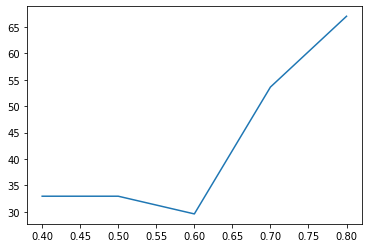

In [177]:
values = []
thres = [0.4,0.5,0.6,0.7,0.8]
for i in thres:
    pred = list(predict(a3,i))
    values.append(accuracy(pred,y_test))
sns.lineplot(thres,values)